In [1]:
import pandas as pd
from biom import Table
import numpy as np
import qiime2 as q2
from skbio.stats.distance import permanova
#from qiime2.plugins.mmvec.actions import paired_omics, summarize_single                                   
from gemelli.rpca import joint_rpca, feature_correlation_table, rpca

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import norm
from skbio.stats.composition import (closure, alr, alr_inv)
from numpy.random import (poisson, lognormal, randint, normal)

### Define functions

In [2]:
def gradient(g, mu, sigma, peaks=None):
    """
    This generates an urn simulating a chain of interacting species.
    This commonly occurs in the context of a redox tower, where
    multiple species are distributed across a gradient.
    Parameters
    ----------
    g: array_like
       Vector of values associated with an underlying gradient.
    mu: array_like
       Vector of means.
    sigma: array_like
       Vector of standard deviations.
    peaks : array_like
       Vector of peaks
    rng: np.random.RandomState
       Numpy random state.
    Returns
    -------
    np.array
       A matrix of real-valued positive abundances where
       there are `n` rows and `m` columns where `n` corresponds
       to the number of samples along the `gradient` and `m`
       corresponds to the number of species in `mus`.
    """
    if peaks is None:
        peaks = np.ones(len(mu))

    xs = [peaks[i] * norm.pdf(g, loc=mu[i], scale=sigma[i])
          for i in range(len(mu))]
    return np.vstack(xs).T

def blocks(ncols, nrows, nblocks, overlap=0, minval=0, sigma=2, maxval=1.0):
    """
    Generate block diagonal with Gaussian distributed values within blocks.

    Parameters
    ----------

    ncol : int
        Number of columns

    nrows : int
        Number of rows

    nblocks : int
        Number of blocks, mucst be greater than one

    overlap : int
        The Number of overlapping columns (Default = 0)

    minval : int
        The min value output of the table (Default = 0)

    maxval : int
        The max value output of the table (Default = 1)


    Returns
    -------
    np.array
        Table with a block diagonal where the rows represent samples
        and the columns represent features.  The values within the blocks
        are gaussian distributed between 0 and 1.
    Note
    ----
    The number of blocks specified by `nblocks` needs to be greater than 1.

    """

    if nblocks <= 1:
        raise ValueError('`nblocks` needs to be greater than 1.')
    mat = np.zeros((nrows, ncols))
    gradient = np.linspace(0, 10, nrows)
    mu = np.linspace(0, 10, ncols)
    xs = [norm.pdf(gradient, loc=mu[i], scale=sigma)
          for i in range(len(mu))]
    mat = np.vstack(xs).T
    block_cols = ncols // nblocks #(nblocks * 2)
    block_rows = nrows // nblocks 

    for b in range(nblocks - 1):

        gradient = np.linspace(
            5, 5, block_rows)  # samples (bock_rows)
        # features (block_cols+overlap)
        mu = np.linspace(0, 10, block_cols + overlap)
        xs = [norm.pdf(gradient, loc=mu[i], scale=sigma)
              for i in range(len(mu))]

        B = np.vstack(xs).T * maxval
        lower_row = block_rows * b
        upper_row = min(block_rows * (b + 1), nrows)
        lower_col = block_cols * b
        upper_col = min(block_cols * (b + 1), ncols)

        if b == 0:
            mat[lower_row:upper_row,
                lower_col:int(upper_col + overlap)] = B
        else:
            ov_tmp = int(overlap / 2)
            if (B.shape) == (mat[lower_row:upper_row,
                                 int(lower_col - ov_tmp):
                                 int(upper_col + ov_tmp + 1)].shape):
                mat[lower_row:upper_row, int(
                    lower_col - ov_tmp):int(upper_col + ov_tmp + 1)] = B
            elif (B.shape) == (mat[lower_row:upper_row,
                                   int(lower_col - ov_tmp):
                                   int(upper_col + ov_tmp)].shape):
                mat[lower_row:upper_row, int(
                    lower_col - ov_tmp):int(upper_col + ov_tmp)] = B
            elif (B.shape) == (mat[lower_row:upper_row,
                                   int(lower_col - ov_tmp):
                                   int(upper_col + ov_tmp - 1)].shape):
                mat[lower_row:upper_row, int(
                    lower_col - ov_tmp):int(upper_col + ov_tmp - 1)] = B

    upper_col = int(upper_col - overlap) 
    # Make last block fill in the remainder
    gradient = np.linspace(5, 5, nrows - upper_row)
    mu = np.linspace(0, 10, ncols - upper_col)
    xs = [norm.pdf(gradient, loc=mu[i], scale=sigma)
          for i in range(len(mu))]
    B = np.vstack(xs).T * maxval

    mat[upper_row:, upper_col:] = B

    return mat

def input_matrix_validation(mat, depths):

    if np.any(depths <= 0):
        raise ValueError("Read depth cannot have values "
                         "less than or equal to zero")
    if depths.ndim != 2:
        raise ValueError("Read depth can only have two dimensions")
    if depths.shape[0] != mat.shape[0]:
        raise ValueError("Number of est. read depth does not match number of "
                         "samples in the input matrix")
    # check matrix and ensure
    # data is proportions
    mat = closure(mat)

    return mat

def output_matrix_validation(sim):

    # ensure no zero counts
    sim[sim < 0.0] = 0.0
    # remove zero sums and return a mask (if needed)
    zero_sum_mask_rows = sim.sum(1) > 0
    sim = sim[zero_sum_mask_rows]
    zero_sum_mask_columns = sim.sum(0) > 0
    sim = sim[:, zero_sum_mask_columns]

    return sim, zero_sum_mask_rows, zero_sum_mask_columns

def poisson_lognormal(mat, depths, kappa=1):

    """
    Simulate from counts, probabilities, or
    proportions of input matrix with a
    Poisson Log-Normal distribution.

    Parameters
    ----------
    mat: array_like
        matrix of strictly positive counts
        or probabilities/proportions.
        columns = features (components)
        rows = samples (compositions)
    depth : array_like
        Read depth of the simulation
        for each sample (row).
    kappa: float
        Over-dispersion parameter.
        Default is 1.

    Returns
    -------
    array_like, np.int
       A matrix of counts simulated from
       the input mat by the distribution.
    list, bool
        Mask of rows that summed to zero
    list, bool
        Mask of columns that summed to zero

    Raises
    ------
    ValueError
       Raises an error if any depths are equal
       or less than zero.
    ValueError
       Raises an error if any depths does not have
       exactly 2 dimensions.
    ValueError
       Raises an error if any depths shape does not match the
       input matrix.
    ValueError
       Raises an error if any values are negative.
    ValueError
       Raises an error if the matrix has more than 2 dimension.
    ValueError
       Raises an error if there is a row that has all zeros.

    """

    # check matrix and ensure
    # data is proportions
    mat = input_matrix_validation(mat, depths)
    # simulate from proportions
    mu = depths * mat
    sim = np.vstack([poisson(lognormal(np.log(mu[i, :]), kappa))
                     for i in range(mat.shape[0])])

    return output_matrix_validation(sim)

def add_noise(mat,
              pseudocount=1,
              percent_normal=0.1,
              percent_random=0.1,
              random_count=1,
              add_missing_at_random=False,
              percent_missing=0.1):
    """
    This function transforms count data into
    the simplex with the ALR This gives the
    data an approximate normal distibution,
    allowing for the addition of normal
    and randomly distributed noise. The data
    is transformed into proportions with the
    inverse alr and then missing values can be
    added, either to match the input or at random.

    Parameters
    ----------
    mat: array_like
        matrix of strictly positive counts
        or probabilities/proportions.
        columns = features (components)
        rows = samples (compositions)
    pseudocount: float
        Pseudocount to add for ALR.
        Default is 1.
    percent_normal: float
        Percent of data to add homoscedastic
        noise. Default is 0.1 (i.e. 10%)
    percent_random: float
        Percent of data to add heteroscedastic
        noise. Default is 0.1 (i.e. 10%)
    random_count: float
        Intensity of random data added.
        Default is 1 (ten would be large).
    add_missing_at_random: bool
        If missing values should match the input
        mat. If True percent_missing is ignored.
    percent_missing: float
        Percent of data to add missing (zero)
        values. Default is 0.1 (i.e. 10%)

    Returns
    -------
    array_like, np.float
       A matrix of noisy proportions.

    Raises
    ------
    ValueError
       Raises an error if any values are negative.
    ValueError
       Raises an error if the matrix has more than 2 dimension.
    ValueError
       Raises an error if there is a row that has all zeros.
    """

    # transform mat into ALR space for
    # adding normal dist. noise
    mat_noise = alr(mat + pseudocount)

    # add homo-scedastic noise
    err = percent_normal * np.ones_like(mat_noise)
    mat_noise = normal(mat_noise, err)

    # add hetero-scedastic noise
    err = percent_random * np.ones_like(mat_noise)
    n_entries = int(percent_random * np.count_nonzero(mat_noise))
    i = randint(0, err.shape[0], n_entries)
    j = randint(0, err.shape[1], n_entries)
    err[i, j] = random_count
    mat_noise = normal(mat_noise, err)

    # transform back
    mat_noise = alr_inv(mat_noise)

    # finally add sparsity
    # Note: there will be no zeros after
    #       using the pseudocount
    if add_missing_at_random:
        n_entries = int(percent_missing * np.count_nonzero(mat_noise))
        i = randint(0, mat_noise.shape[0], n_entries)
        j = randint(0, mat_noise.shape[1], n_entries)
        mat_noise[i, j] = 0
    else:
        i, j = np.nonzero(mat == 0)
        mat_noise[i, j] = 0

    return mat_noise

In [3]:
def simple_blocks(n_samp,
                  n_feat,
                  omic_id='omic1',
                  n_blocks=3,
                  kappa=0.5,
                  sigma=2,
                  overlap=0,
                  pseudocount=1,
                  percent_normal=0.5,
                  percent_random=0.5,
                  random_count=8,
                  add_missing_at_random=True,
                  percent_missing=0.2):

    if n_samp % n_blocks != 0:
        raise ValueError('n_samp must be a multiple of n_blocks')
    block_sim = blocks(n_feat, n_samp, n_blocks,
                       sigma=sigma, overlap=overlap,
                       minval=0, maxval=10000)
    block_sim = block_sim[::-1, ::-1]
    #add omic in front of sample and feature ids
    samp_ids = ['s%i' % i for i in range(n_samp)]
    feat_ids = ['%s_f%i' % (omic_id, i) for i in range(n_feat)]
    #feat_ids = ['f%i' % (i )for i in range(n_feat)]
    block_sim_df = pd.DataFrame(block_sim, samp_ids, feat_ids)
    block_sim_bt = Table(block_sim_df.values.T, block_sim_df.columns, block_sim_df.index)
    table = Table(block_sim_df.values, block_sim_df.index, block_sim_df.columns)
    mat = table.matrix_data.toarray().T
    depths = table.sum('sample').reshape(table.shape[1], -1) * 100
    mat = add_noise(mat, pseudocount, percent_normal,
                    percent_random, random_count,
                    add_missing_at_random, percent_missing)
    sim_res = poisson_lognormal(mat, depths, kappa=kappa)
    simulation_table = Table(sim_res[0],
                             table.ids()[sim_res[1]],
                             table.ids("observation")[sim_res[2]])
    chunck = n_samp // n_blocks
    mf_sim = pd.DataFrame(['g%i' % (i) for i in range(n_blocks)
                           for j in range(chunck)], samp_ids, ['groups'])

    
    return block_sim_bt, simulation_table, mf_sim

### Plots for figure 1

300


/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_1787/2841876017.py:214: RuntimeWarning: divide by zero encountered in log
  sim = np.vstack([poisson(lognormal(np.log(mu[i, :]), kappa))


0.9


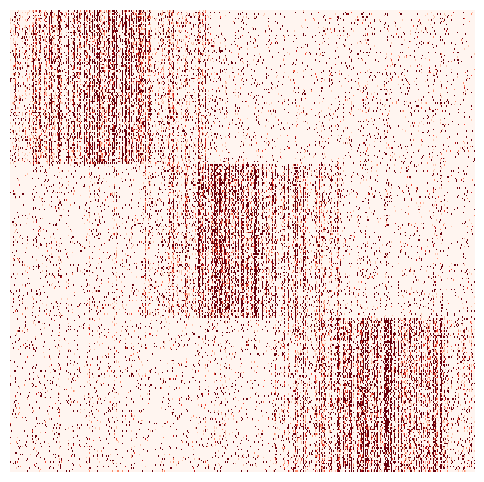

600
0.8


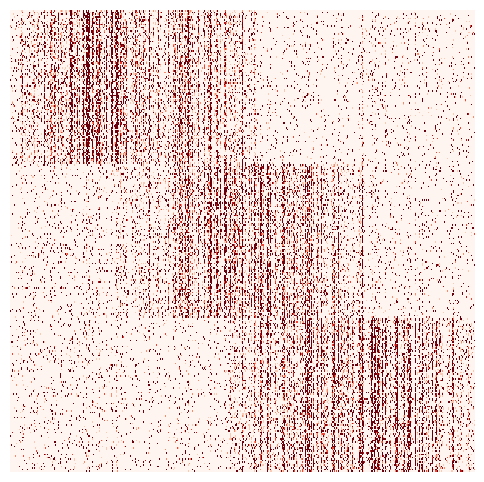

900
0.7


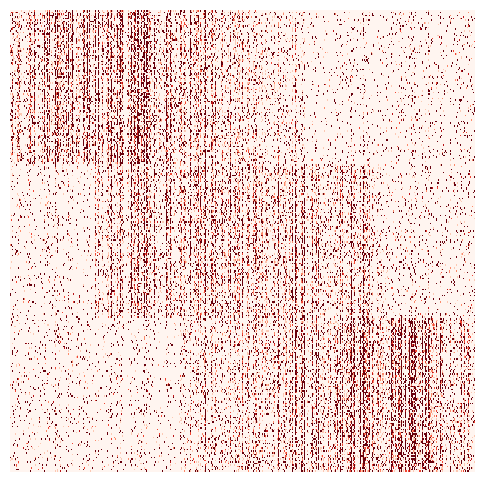

In [9]:
n_samples = 300
n_features = 1500 * 2
tables_example = {}

for p_overlap, omic_id in zip([0.1, 0.2, 0.3], ['omic1', 'omic2', 'omic3']): 
    
    overlap_ = int(n_features * p_overlap)
    print(overlap_)
    
    fig, ax2 = plt.subplots(1, 1, figsize=(20//3, 6))

    # build simple three block model
    bt_base_tmp, bt_sim_tmp, mf_sim_tmp = simple_blocks(n_samples, n_features, omic_id=omic_id,
                                                        overlap=overlap_, n_blocks=3)
    tables_example[p_overlap] = bt_sim_tmp.copy()
    ax2.imshow(bt_sim_tmp.matrix_data.toarray().T, cmap='Reds', aspect='auto', interpolation='nearest', vmax=5)

    #ax2.set_title('Simulated\n(Noise + PLN subsample)',
    #                  color='black',
    #                  fontsize=22)

    for ax in [ax2]:
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)

        ax.set_ylabel('',
                          color='black',
                          fontsize=22)
        ax.set_xlabel('',
                          color='black',
                          fontsize=22)
    print(1-p_overlap)
    # plt.savefig('../results/joint-rpca/Simulations/effect-sizes-%f.pdf' % (1 - p_overlap), dpi=600, 
    #             bbox_inches='tight',
    #             facecolor=fig.get_facecolor(), 
    #             edgecolor='none')
    plt.savefig('../results/joint-rpca/Simulations/effect-sizes-%f.svg' % (1 - p_overlap), dpi=600, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.show()


/Users/biacordazzo/Desktop/bia_gemelli/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/Users/biacordazzo/Desktop/bia_gemelli/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/Users/biacordazzo/Desktop/bia_gemelli/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/Users/biacordazzo/Desktop/bia_gemelli/gemelli/rpca.py:902: RuntimeWarning: Removing 0 features(s) in table(s) but not the ordination.
  warnings.warn('Removing %i features(s) in table(s)'


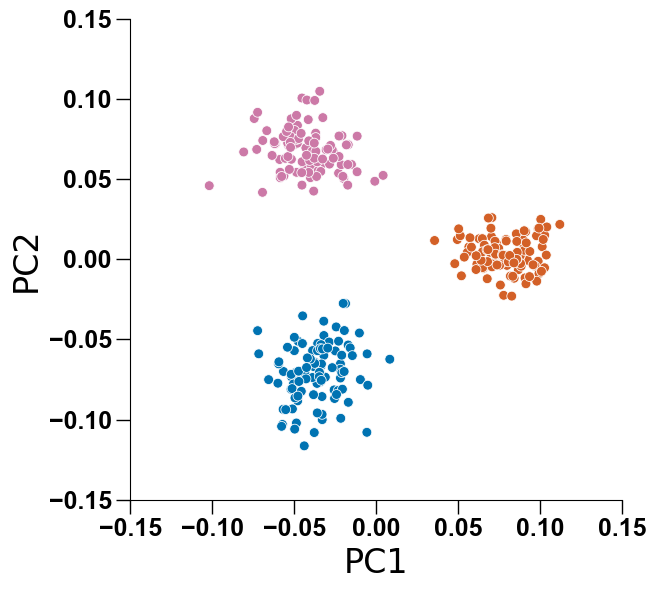

In [10]:
true_lbls = list(mf_sim_tmp[mf_sim_tmp.groups == 'g0'].index[:1]) + \
            list(mf_sim_tmp[mf_sim_tmp.groups == 'g1'].index[:1]) + \
            list(mf_sim_tmp[mf_sim_tmp.groups == 'g2'].index[:1])
mf_sim_tmp['train_test'] = 'train'
mf_sim_tmp.loc[true_lbls, 'train_test'] = 'test'

pal_ = {'g0':'#0073B2',
        'g1':'#D36027',
        'g2':'#CC79A7'}

for joint_use_add in [[0.1, 0.2, 0.3]]:
    ord_, _, _ = joint_rpca([tables_example[joint_use_x].copy()
                             for joint_use_x in joint_use_add],
                            max_iterations=15,
                            sample_metadata=mf_sim_tmp,
                            train_test_column='train_test')
    ord_plt = pd.concat([ord_.samples, mf_sim_tmp], axis=1)
    ord_plt = ord_plt[ord_plt.train_test == 'train']

    fig, ax3 = plt.subplots(1, 1, figsize=(20/3, 6))

    sns.scatterplot(x='PC2', y='PC1', hue='groups', data=ord_plt, 
                    s=50, ax=ax3, palette=pal_)

    #ax3.set_title('Joint-RPCA',
                      #color='black',
                      #fontsize=22)
    ax3.set_ylabel('PC2',
                      color='black',
                      fontsize=24)
    ax3.set_xlabel('PC1',
                      color='black',
                      fontsize=24)

    ax = ax3
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)

    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
    ax.tick_params(axis='y', colors='black', width=1, length=10)
    ax.tick_params(axis='x', colors='black', width=1, length=10)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(18)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(18)
    ax.legend_.remove()
    
    ax.set_ylim(-.15, .15)
    ax.set_xlim(-.15, .15)
    ax.spines['left'].set_bounds(-.15, .15)
    ax.spines['bottom'].set_bounds(-.15, .15)
    
    plt.tight_layout()
    # plt.savefig('../results/joint-rpca/Simulations/joint-RPCA-scatter.pdf', dpi=600, 
    #             bbox_inches='tight',
    #             facecolor=fig.get_facecolor(), 
    #             edgecolor='none')
    plt.show()


In [11]:
feature_feature_correlation = feature_correlation_table(ord_)
feature_feature_correlation.head()

featureid,omic1_f0,omic1_f1,omic1_f2,omic1_f3,omic1_f4,omic1_f5,omic1_f6,omic1_f7,omic1_f8,omic1_f9,...,omic3_f2990,omic3_f2991,omic3_f2992,omic3_f2993,omic3_f2994,omic3_f2995,omic3_f2996,omic3_f2997,omic3_f2998,omic3_f2999
featureid,,,,,,,,,,,,,,,,,,,,,
omic1_f0,1.000000,0.641150,-0.556814,0.922478,-0.769715,0.541245,-0.572319,0.826922,0.156478,0.617856,...,0.843419,0.649900,-0.964693,0.522968,-0.689945,-0.135554,-0.295773,-0.745464,-0.191015,-0.496878
omic1_f1,0.641150,1.000000,-0.844971,0.882549,-0.895379,0.982091,-0.170940,0.172275,-0.640538,0.808555,...,0.714448,0.569976,-0.416404,0.929457,-0.407842,0.602669,0.503041,-0.787799,-0.788060,-0.450119
omic1_f2,-0.556814,-0.844971,1.000000,-0.716513,0.566440,-0.907247,-0.260194,-0.331789,0.638219,-0.992510,...,-0.873958,-0.880801,0.371166,-0.974016,-0.030549,-0.718949,-0.242089,0.955260,0.903513,-0.069006
omic1_f3,0.922478,0.882549,-0.716513,1.000000,-0.934878,0.802506,-0.486963,0.563373,-0.206893,0.732643,...,0.828939,0.622691,-0.789809,0.750545,-0.671219,0.185872,0.091974,-0.802787,-0.472234,-0.584402
omic1_f4,-0.769715,-0.895379,0.566440,-0.934878,1.000000,-0.795543,0.591281,-0.277564,0.308950,-0.547439,...,-0.589814,-0.337108,0.603615,-0.677830,0.771285,-0.213840,-0.359203,0.591594,0.433395,0.782826


In [12]:
# Transform it in a links data frame (3 columns only):
links = feature_feature_correlation.stack()
links.index.set_names(['axis1', 'axis2'], inplace=True)
links = links.reset_index()
links.columns = ['var1', 'var2', 'value']
links.head()

,var1,var2,value
0,omic1_f0,omic1_f0,1.000000
1,omic1_f0,omic1_f1,0.641150
2,omic1_f0,omic1_f2,-0.556814
3,omic1_f0,omic1_f3,0.922478
4,omic1_f0,omic1_f4,-0.769715


In [13]:
# Keep only correlations within a threshold -- this is for fig clarity
links_filtered = links.loc[(links.value.abs() > 0.6) \
                           & (links.value.abs() < 0.9)]
links_filtered.head()

,var1,var2,value
1,omic1_f0,omic1_f1,0.641150
4,omic1_f0,omic1_f4,-0.769715
7,omic1_f0,omic1_f7,0.826922
9,omic1_f0,omic1_f9,0.617856
14,omic1_f0,omic1_f14,-0.835453


In [14]:
#sort within each omic and keep top 10 features
feat_ids = []

for omic in ['omic1', 'omic2', 'omic3']:
    links_filtered_omic = links_filtered[(links_filtered.var1.str.contains(omic)) & 
                                         (links_filtered.var2.str.contains(omic))]
    links_filtered_omic = links_filtered_omic.sort_values(by=(['var1', 'value']), ascending=False)
    #keep only the top 15
    feat_ids.extend(links_filtered_omic.var2[:10])

feature_feature_correlation_sub = feature_feature_correlation.loc[feat_ids, feat_ids]

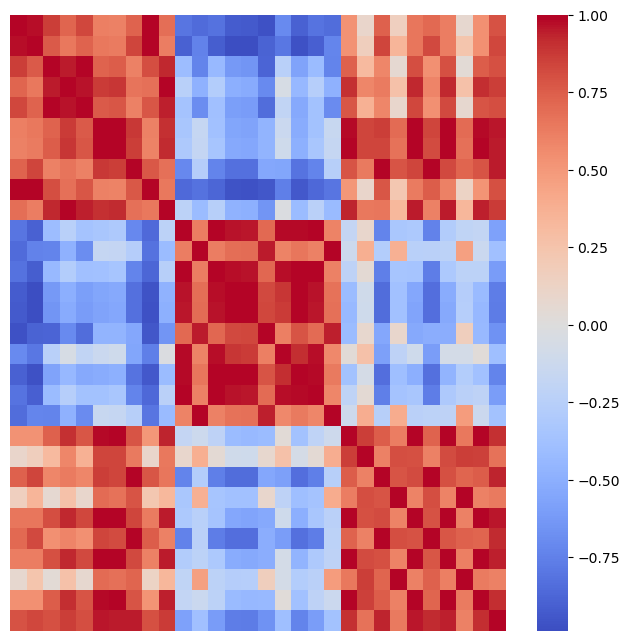

In [21]:
#plot heatmap of feature-feature correlation
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(feature_feature_correlation_sub, 
            cmap='coolwarm', center=0, ax=ax,
            xticklabels=False, yticklabels=False)
plt.ylabel('')
plt.xlabel('')
plt.savefig('../results/joint-rpca/Simulations/fig1_corr_small2.pdf', dpi=600, 
                bbox_inches='tight',
                #facecolor=fig.get_facecolor(), 
                edgecolor='none')
plt.show()

In [18]:
#take the last four features from each omic
feat_ids_sub = []

for omic in ['omic1', 'omic2', 'omic3']:
    omic_ = [x for x in feat_ids if omic in x]
    feat_ids_sub.extend(omic_[:4])

feature_feature_correlation_sub2 = feature_feature_correlation.loc[feat_ids_sub, feat_ids_sub]

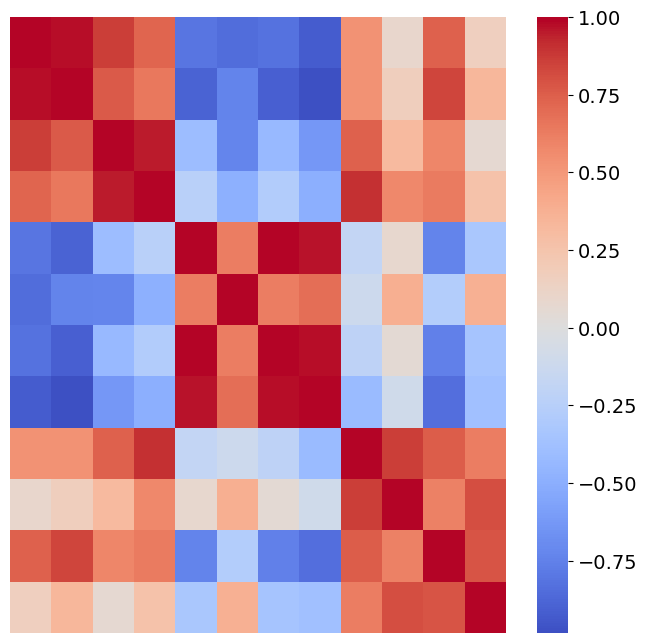

In [20]:
#plot heatmap of feature-feature correlation
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(feature_feature_correlation_sub2, 
            cmap='coolwarm', center=0, ax=ax,
            xticklabels=False, yticklabels=False)
plt.ylabel('')
plt.xlabel('')
#increase font size from colorbar
cbar = ax.collections[0].colorbar
#cbar.set_ticks([-1, -0.25, -0.5, -0.75, 0, 
#                0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=14)
#include -1 and 1 in colorbar
plt.savefig('../results/joint-rpca/Simulations/fig1_corr_smaller2.pdf', dpi=600, 
                bbox_inches='tight',
                #facecolor=fig.get_facecolor(), 
                edgecolor='none')
plt.show()

### alternative version with two phenotypes

300


/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_19953/2841876017.py:214: RuntimeWarning: divide by zero encountered in log
  sim = np.vstack([poisson(lognormal(np.log(mu[i, :]), kappa))


0.9


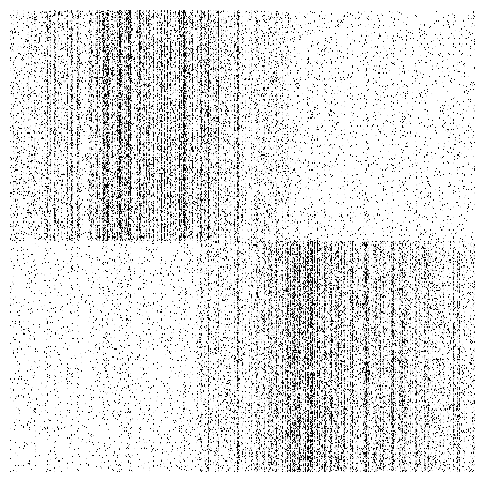

600


/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_19953/2841876017.py:214: RuntimeWarning: divide by zero encountered in log
  sim = np.vstack([poisson(lognormal(np.log(mu[i, :]), kappa))


0.8


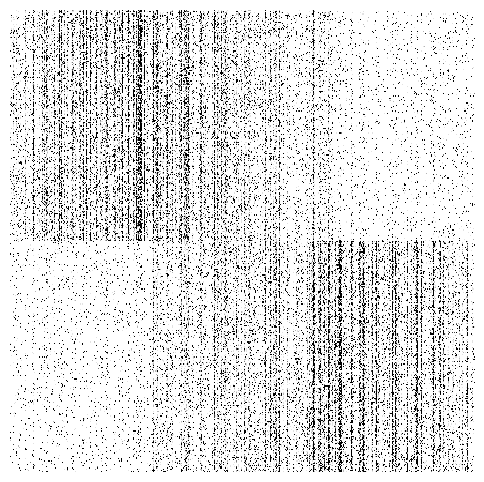

900


/var/folders/wc/r9njmvn106j5gvr496l3xw65jl16p6/T/ipykernel_19953/2841876017.py:214: RuntimeWarning: divide by zero encountered in log
  sim = np.vstack([poisson(lognormal(np.log(mu[i, :]), kappa))


0.7


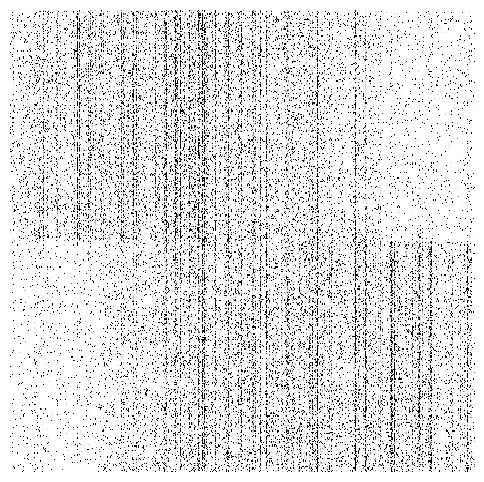

In [5]:
n_samples = 400
n_features = 1500 * 2
tables_example = {}

for p_overlap, omic_id in zip([0.1, 0.2, 0.3], ['omic1', 'omic2', 'omic3']): 
    
    overlap_ = int(n_features * p_overlap)
    print(overlap_)
    
    fig, ax2 = plt.subplots(1, 1, figsize=(20//3, 6))

    # build simple three block model
    bt_base_tmp, bt_sim_tmp, mf_sim_tmp = simple_blocks(n_samples, n_features, omic_id=omic_id,
                                                        overlap=overlap_, n_blocks=2)
    tables_example[p_overlap] = bt_sim_tmp.copy()
    ax2.imshow(bt_sim_tmp.matrix_data.toarray().T, cmap='Grays', aspect='auto', interpolation='nearest', vmax=5)

    for ax in [ax2]:
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)

        ax.set_ylabel('',
                          color='black',
                          fontsize=22)
        ax.set_xlabel('',
                          color='black',
                          fontsize=22)
    print(1-p_overlap)
    plt.savefig('../results/joint-rpca/Simulations/2-blocks-effect-sizes-%f.pdf' % (1 - p_overlap), 
                dpi=800, 
                bbox_inches='tight',
                facecolor=fig.get_facecolor(), 
                edgecolor='none')
    plt.show()
